In [2]:
!pip install MLB-StatsAPI

     |████████████████████████████████| 40kB 147kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


## Project: Building MLB playoff odd predicting System


Can we design a predictive model capable of accurately predicting MLB playoff odd?



### Steps
1.We will clean our dataset

2.Split it into training and testing data 

3.Train several different classifiers on the data -Logistic Regression -Support Vector Machine -XGBoost etc.

4.Use the best Classifer to predict MLB playoff odd


MLB.com provides the stats of the AL/NL teams such as Batting average, OPS (On-base Plus Slugging), ERA (Earned Runs Average), WHIP(Walks Plus Hits Divided by Innings Pitched), etc. (http://mlb.mlb.com/stats/)

And there are API that provides get some stats of MLB with Python. You need to install it with  pip install MLB-StatsAPI

Based on the Hitting, Pitching, and Fielding stats for division winners of the last 10 years, we can make a machine learning model with classification methods. 

With this model, let's figure out which team is going to advance to the playoff.

Note: Code and Markdown cells can be executed using the Shift + Enter keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

Question 1 - Classification vs. Regression
Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?

Answer:

Classification. As the predicted attribute is a categorical (Playoff qualified= 1 / not qualified =0).

In [26]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt
%matplotlib inline

# import MLB-StatsAPI
import statsapi as mlb

In [27]:
standings_2018 = mlb.standings(season=2018,standingsTypes='byLeague')
print(standings_2018)

American League East
Rank Team                   W   L   GB  (E#) WC Rank WC GB (E#)
 1   Boston Red Sox        108 54   -    -      -      -    E  
 2   New York Yankees      100 62  8.0   E      1    +3.0   -  
 3   Tampa Bay Rays        90  72  18.0  E      3     7.0   E  
 4   Toronto Blue Jays     73  89  35.0  E      7    24.0   E  
 5   Baltimore Orioles     47  115 61.0  E     12    50.0   E  

American League West
Rank Team                   W   L   GB  (E#) WC Rank WC GB (E#)
 1   Houston Astros        103 59   -    -      -      -    E  
 2   Oakland Athletics     97  65  6.0   E      2      -    -  
 3   Seattle Mariners      89  73  14.0  E      4     8.0   E  
 4   Los Angeles Angels    80  82  23.0  E      5    17.0   E  
 5   Texas Rangers         67  95  36.0  E      8    30.0   E  

American League Central
Rank Team                   W   L   GB  (E#) WC Rank WC GB (E#)
 1   Cleveland Indians     91  71   -    -      -      -    E  
 2   Minnesota Twins       78  84  1

In [28]:
df = pd.read_csv('mlb_standing.csv')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 57 columns):
Unnamed: 0    570 non-null int64
Year          570 non-null float64
RK_x          570 non-null int64
Team          570 non-null object
League_x      570 non-null object
G_x           570 non-null int64
AB            570 non-null int64
R_x           570 non-null int64
H_x           570 non-null int64
2B            570 non-null int64
3B            570 non-null int64
HR_x          570 non-null int64
RBI           570 non-null int64
BB_x          570 non-null int64
SO_x          570 non-null int64
SB_x          570 non-null int64
CS_x          570 non-null int64
AVG▼_x        570 non-null float64
OBP           570 non-null float64
SLG           570 non-null float64
OPS           570 non-null float64
RK_y          570 non-null int64
League_y      570 non-null object
W             570 non-null int64
L             570 non-null int64
ERA           570 non-null float64
G_y           570 non-

### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:

-The total number of teams, n_teams.
-The total number of features for each team, n_features.
-The number of those teams who passed playoff, n_passed.
-The number of those teams who failed playoff, n_failed.
-The Playoff pass rate of the class, Playoff_rate, in percent (%).

In [30]:
# TODO: Calculate number of teamss
n_teams = len(df)

# TODO: Calculate number of features
n_features = df.shape[1]

# TODO: Calculate passing teams
n_qualified = sum(df['Playoff']==1)

# TODO: Calculate failing teams
n_failed = sum(df['Playoff']==0)

# TODO: Calculate Playoff pass rate
Playoff_qualified_rate = np.divide(np.double(n_qualified) , n_failed) *100
# Print the results
print ("Total number of teams: {}".format(n_teams))
print ("Number of features: {}".format(n_features))
print ("Number of teams who qualified: {}".format(n_qualified))
print ("Number of teams who failed: {}".format(n_failed))
print ("Playoff qualifiers rate of the MLB: {:.2f}%".format(Playoff_qualified_rate))

Total number of teams: 570
Number of features: 57
Number of teams who qualified: 152
Number of teams who failed: 418
Playoff qualifiers rate of the MLB: 36.36%


### Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

#### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [31]:
features = ['AVG▼_x', 'OPS' , 'ERA', 'WHIP', 'FPCT▼', 'DER']

In [32]:
# Let's check the features for advanced team
df.loc[df['Playoff'] == 1, features].describe()

,AVG▼_x,OPS,ERA,WHIP,FPCT▼,DER
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.265368,0.765901,3.857829,1.293684,0.984237,0.696421
std,0.011196,0.032390,0.389936,0.071675,0.002272,0.010318
min,0.238000,0.689000,2.940000,1.100000,0.978000,0.672000
25%,0.257000,0.739750,3.590000,1.240000,0.983000,0.689000
50%,0.265000,0.767000,3.835000,1.290000,0.984000,0.695500
75%,0.273000,0.786000,4.105000,1.332500,0.986000,0.703250
max,0.290000,0.851000,4.760000,1.500000,0.989000,0.731000


In [33]:
# Extract feature columns
# Set features with Batting AVG, OPS, ERA, Pitching AVG, WHIP, FPCT, DER

"""
AVG▼_x : Batting Average
OPS : On base Plus Slugging
ERA : Earned Run Average
WHIP : Walks plus Hits divided by Innings Pitched
FPCT▼ : Fielding PerCenTage
DEF : Defense Efficiency Ratio (1 - ((H + ROE - HR) / (PA - BB - SO - HBP - HR)))
feature_cols = list(df[features])
"""
feature_cols = df[features]
# Extract target column 'qualified'
target_col = df.Playoff

# Show the list of columns
print ("Feature columns:\n{}".format(feature_cols))
print ("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = df[feature_cols]

# Show the feature information by printing the first five rows
print ("\nFeature values:")
print (X_all.head())

Feature columns:
     AVG▼_x    OPS   ERA  WHIP  FPCT▼    DER
0     0.268  0.792  3.75  1.25  0.987  0.694
1     0.259  0.766  3.77  1.20  0.986  0.689
2     0.258  0.740  3.74  1.20  0.986  0.709
3     0.258  0.744  3.65  1.31  0.983  0.702
4     0.257  0.742  3.75  1.28  0.986  0.710
5     0.256  0.757  4.33  1.31  0.988  0.690
6     0.255  0.754  3.11  1.10  0.989  0.707
7     0.254  0.722  4.13  1.24  0.985  0.691
8     0.254  0.753  4.04  1.25  0.989  0.703
9     0.254  0.729  4.63  1.40  0.984  0.685
10    0.254  0.725  4.00  1.31  0.982  0.687
11    0.252  0.747  3.73  1.24  0.982  0.706
12    0.252  0.764  3.81  1.21  0.985  0.717
13    0.250  0.774  3.38  1.15  0.983  0.699
14    0.250  0.723  4.50  1.38  0.984  0.685
15    0.249  0.781  3.78  1.24  0.984  0.687
16    0.249  0.730  3.85  1.34  0.978  0.688
17    0.245  0.697  4.94  1.46  0.987  0.680
18    0.244  0.739  4.85  1.41  0.983  0.679
19    0.242  0.726  4.15  1.32  0.987  0.694
20    0.241  0.680  4.58  1.34  0.984 

ValueError: Must pass DataFrame with boolean values only

### Implementation: Training and Testing Data Split
So far, we have converted all categorical features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:

Randomly shuffle and split the data (X_all, y_all) into training and testing subsets.
ints (approximately 25%).
Set a random_state for the function(s) you use, if provided.
Store the results in X_train, X_test, y_train, and y_test.

In [34]:
# TODO: Import any additional functionality you may need here
from sklearn.model_selection import train_test_split
X =  df[features]

print(X.head())

y = df['Playoff']

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=27)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

   AVG▼_x    OPS   ERA  WHIP  FPCT▼    DER
0   0.268  0.792  3.75  1.25  0.987  0.694
1   0.259  0.766  3.77  1.20  0.986  0.689
2   0.258  0.740  3.74  1.20  0.986  0.709
3   0.258  0.744  3.65  1.31  0.983  0.702
4   0.257  0.742  3.75  1.28  0.986  0.710
Training set has 456 samples.
Testing set has 114 samples.


### Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in scikit-learn. You will first discuss the reasoning behind choosing these four models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F1 score. You will need to produce four tables (one for each model) that shows the training set size, training time, prediction time, F1 score on the training set, and F1 score on the testing set.

The following supervised learning models are currently available in scikit-learn that you may choose from:

Gaussian Naive Bayes (GaussianNB)
Decision Trees
Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
K-Nearest Neighbors (KNeighbors)
Stochastic Gradient Descent (SGDC)
Support Vector Machines (SVM)
Logistic Regression
Question 2 - Model Application
List four supervised learning models that are appropriate for this problem. For each model chosen

Describe one real-world application in industry where the model can be applied. (You may need to do a small bit of research for this — give references!)
What are the strengths of the model; when does it perform well?
What are the weaknesses of the model; when does it perform poorly?
What makes this model a good candidate for the problem, given what you know about the data?
Let's take a look at supervised learning alogrithms that are both applicable and non-applicable to this problem.

Answer: 

Gaussian Naive Bayes Classifier (NB)

Overview:
Naive Bayes classifies samples by applying Bayes’ theorem with the “naive” assumption of independence between every pair of features. The time and space complexity of Naive Bayes Classifier are both O(m*n) where m is the number of features and n is the number of samples. Naive Bayes classification algorithm calculates P(y|x) for all the features of all the samples therefore needs m*n steps and memory cells. One remarkable application of Naive Bayes classifier is text classification, such as filtering spams based on a bag-of-words model.

Pros:

Easy implementation.
Low computation cost.
Low sensitivity to irrelevant data.
Cons[1]:

Intrinsic weakness due to the assumption that all features are idependent from each other which may lead to unsatisfying classification reasult for combination of features.
Can be fooled by zero frequencies[4].
Why Chosen:
For this assignment, a quick Gaussian Naive Bayes classifier is chosen as a baseline case for the classification problem.

[1]Quora answer

Support Vector Machines Classifier (SVM)

Overview: 
SVM classifies samples by a separating hyperplane. It is flexible with non-traditional data input, eg. string, which makes it versatile in many applications, such as, text classification, image classification, bioinformatics (protein classification, cancer classification) and hand-written character classification. The time and space complexity of SVM classifier are both O(n3) where n is the sample size[2].

Pros[3,4]:

Effective in high dimensional spaces.
Still effective in cases where number of dimensions is greater than the number of samples.
Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.
Overfitting can be controlled by using soft margin.
No local minima in doing the convex optimization.
Cons[3]:

If the number of features is much greater than the number of samples, the method is likely to give poor performances.
SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.
Sensitive to noisy (mis-labeled) data.
The classification results can be very sensitive to the selection of kernel which makes the choice of kernel crucial.
Poor performance on multiclass classification.
Poor performance on highly skewed/imbalanced data sets.
Why Chosen:
Considering the target dataset is relatively small, the cost of computation is not a crucial factor, hence SVM is worth trying.

[2]Core Vector Machines: Fast SVM Training on Very Large Data Sets
[3]Introduction to Support Vector Machines
[4]Support Vector Machines by Andrew W. Moore

K-Nearest Neighbors Classifier (KNN)

Overview:
KNN is a non-parametric, instance-based classifier that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions)[5]. With no training involved, the lazy classifier is powerful in many applications, especially in low-dimensional datasets, computer security(intrusion detection), fault detection in semiconducter manufacturing, video content retrieval, gene expression, protein-protein interaction and 3D structure prediction[6]. The complexity of KNN Classifier is O(n2) where n is the number of data points.

Pros:

Easy implementation.
Naturally handles multiclass classification and regression.
Cons[1,6]:

Expensive and slow to predict new instances.
Must defien a meaningful distance metric function.
Performs poorly on high-dimensionality datases.
Have to tune k.
Doesn't know which attributes are more important
Why Chosen:
Due to our small size dataset, we can try KNN with a quick and easy implementaion.

[5]K Nearest Neighbors - Classification
[6]Machine Learning Algorithm Cheat Sheet

Decision Trees Classifier (DT)

Overview:
DT classifies samples with a tree-like model based on a set of if-then-else decision rules. The standard Decision Tree classifier has a time complexity of O(nm3) and a space complexity of O(n) where n is the number of samples and m is the number of features[7]. Applications of DT include: star classification, medical diagnosis, credit risk analysis.

Pros[7]:

Easy to understand and interpret.
Fast and accurate.
Robust to noise and missing values.
Cons:

Doesn't treat well non-rectangular regions.
Prone to overfitting.
Why Chosen:
Let's also try DT to get an overall comparison of single estimators.

[7]A Fast Decision Tree Learning Algorithm

Ensemble Methods

Overview:
Ensemble methods construct a set of classifiers and then classify new data points by taking a (weighted) vote of their predictions[8]. It performaces well on a variety of applications, such as distributed computing, privacy-preserving applications, large-scale data with reusable models and multiple sources of data.

Pros[9]:

Improves accuracy and robustness over single model methods.
A complex problem can be decomposed into multiple sub-problems that are easier to understand and solve (divide-and-conquer approach).
Cons:

More complex than single estimator.
Prone to overfitting.
High cost of computation.
Why Not Chosen:
Sample size is too small.

[8]Ensemble Methods in Machine Learning
[9]On the Power of Ensemble: Supervised and Unsupervised Methods Reconciled

Stochastic Gradient Descent Classifier (SGD)

Overview[10]:
SGD classifies samples by minimizing an objective function, often a loss function, by iteration. SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing.

Pros:

Scales well with sample size larger than 105.
Efficiency.
Cons:

Requires a number of hyperparameters such as the regularization parameter and the number of iterations.
Sensitive to feature scaling.
Why Not Chosen:
Sample size is too small.

[10]scikit-learn: 1.5. Stochastic Gradient Descent

Setup
Run the code cell below to initialize four helper functions which you can use for training and testing the four supervised learning models you've chosen above. The functions are as follows:

- train_classifier - takes as input a classifier and training data and fits the classifier to the data.
- predict_labels - takes as input a fit classifier, features, and a target labeling and makes predictions using the F1 score.
- train_predict - takes as input a classifier, and the training and testing data, and performs train_clasifier and predict_labels.

This function will report the F1 score for both the training and testing data separately.

In [35]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    # print "Trained model in {:.4f} seconds".format(end - start)
    return end - start

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()

    # Print and return results
    # print "Made predictions in {:.4f} seconds.".format(end - start)
    return (end - start), f1_score(target.values, y_pred, pos_label=1)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    # print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    training_time = train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    training_f1 = predict_labels(clf, X_train, y_train)[1]
    predict_time, test_f1 = predict_labels(clf, X_test, y_test)
    # print "F1 score for training set: {:.4f}.".format(training_f1)
    # print "F1 score for test set: {:.4f}.".format(test_f1)
    return training_time, predict_time, training_f1, test_f1

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the four supervised learning models of your choice and run the train_predict function for each one. Remember that you will need to train and predict on each classifier for four different training set sizes: 100, 200, and 300. Hence, you should expect to have 12 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:

-Import the four supervised learning models you've discussed in the previous section.
-Initialize the four models and store them in clf_A, clf_B, clf_C and clf_D.
    *Use a random_state for each model you use, if provided.
    *Note: Use the default settings for each model — you will tune one specific model in a later section.
-Create the different training set sizes to be used to train each model.
    *Do not reshuffle and resplit the data! The new training points should be drawn from X_train and y_train.
-Fit each model with each training set size and make predictions on the test set (9 in total).
Note: Four tables are provided after the following code cell which can be used to store your results.

In [36]:
import xgboost as xgb

In [37]:
# TODO: Import the four supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

# TODO: Initialize the models
clf_A = GaussianNB()
clf_B = SVC(random_state=912,kernel='rbf')
clf_C = DecisionTreeClassifier(random_state=0)
clf_D = KNeighborsClassifier()
clf_E = LogisticRegression(random_state=42)
clf_F = XGBClassifier(seed = 82)


# TODO: Set up the training set sizes
# make sure to randomly select samples to get the real training time
import random
random.seed(0)

idx_100 = random.sample(list(X_train.index.values), 100)
X_train_100 = X_train.loc[idx_100, :]
y_train_100 = y_train[idx_100]

idx_200 = random.sample(list(X_train.index.values), 200)
X_train_200 = X_train.loc[idx_200, :]
y_train_200 = y_train[idx_200]

X_train_300 = X_train
y_train_300 = y_train


# TODO: Execute the 'train_predict' function for each classifier and each training set size
clf_A_100 = train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
clf_A_200 = train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
clf_A_300 = train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)

clf_B_100 = train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
clf_B_200 = train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
clf_B_300 = train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)

clf_C_100 = train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
clf_C_200 = train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
clf_C_300 = train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

clf_D_100 = train_predict(clf_D, X_train_100, y_train_100, X_test, y_test)
clf_D_200 = train_predict(clf_D, X_train_200, y_train_200, X_test, y_test)
clf_D_300 = train_predict(clf_D, X_train_300, y_train_300, X_test, y_test)


clf_E_100 = train_predict(clf_E, X_train_100, y_train_100, X_test, y_test)
clf_E_200 = train_predict(clf_E, X_train_200, y_train_200, X_test, y_test)
clf_E_300 = train_predict(clf_E, X_train_300, y_train_300, X_test, y_test)

clf_F_100 = train_predict(clf_F, X_train_100, y_train_100, X_test, y_test)
clf_F_200 = train_predict(clf_F, X_train_200, y_train_200, X_test, y_test)
clf_F_300 = train_predict(clf_F, X_train_300, y_train_300, X_test, y_test)


print (clf_A.__class__.__name__)
print (clf_A_100)
print (clf_A_200)
print (clf_A_300)

print (clf_B.__class__.__name__)
print (clf_B_100)
print (clf_B_200)
print (clf_B_300)

print (clf_C.__class__.__name__)
print (clf_C_100)
print (clf_C_200)
print (clf_C_300)

print (clf_D.__class__.__name__)
print (clf_D_100)
print (clf_D_200)
print (clf_D_300)

print (clf_E.__class__.__name__)
print (clf_E_100)
print (clf_E_200)
print (clf_E_300)


print (clf_F.__class__.__name__)
print (clf_F_100)
print (clf_F_200)
print (clf_F_300)

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set g

GaussianNB
(0.0045623779296875, 0.0024251937866210938, 0.7619047619047619, 0.5818181818181819)
(0.003939390182495117, 0.0023899078369140625, 0.7244094488188977, 0.6909090909090909)
(0.004069805145263672, 0.002420663833618164, 0.6813186813186813, 0.6538461538461539)
SVC
(0.00658106803894043, 0.0030050277709960938, 0.0, 0.0)
(0.007770538330078125, 0.0037202835083007812, 0.3902439024390244, 0.21621621621621623)
(0.021251201629638672, 0.005533456802368164, 0.3037974683544304, 0.12903225806451613)
DecisionTreeClassifier
(0.010698080062866211, 0.0020689964294433594, 1.0, 0.5306122448979592)
(0.00400543212890625, 0.0021097660064697266, 1.0, 0.5818181818181819)
(0.006120920181274414, 0.00220489501953125, 1.0, 0.6538461538461539)
KNeighborsClassifier
(0.007374286651611328, 0.005758762359619141, 0.7812499999999999, 0.47058823529411764)
(0.005148172378540039, 0.004402875900268555, 0.8305084745762712, 0.576271186440678)
(0.0040128231048583984, 0.0058782100677490234, 0.7510204081632652, 0.489795918

In [38]:
training_time = {}
training_time['GaussianNB'] = [clf_A_100[0], clf_A_200[0], clf_A_300[0]]
training_time['SVC'] = [clf_B_100[0], clf_B_200[0], clf_B_300[0]]
training_time['DT'] = [clf_C_100[0], clf_C_200[0], clf_C_300[0]]
training_time['KNN'] = [clf_D_100[0], clf_D_200[0], clf_D_300[0]]
training_time['RL'] = [clf_E_100[0], clf_E_200[0], clf_E_300[0]]
training_time['XGB'] = [clf_F_100[0], clf_F_200[0], clf_F_300[0]]

predict_time = {}
predict_time['GaussianNB'] = [clf_A_100[1], clf_A_200[1], clf_A_300[1]]
predict_time['SVC'] = [clf_B_100[1], clf_B_200[1], clf_B_300[1]]
predict_time['DT'] = [clf_C_100[1], clf_C_200[1], clf_C_300[1]]
predict_time['KNN'] = [clf_D_100[1], clf_D_200[1], clf_D_300[1]]
training_time['RL'] = [clf_E_100[1], clf_E_200[1], clf_E_300[1]]
training_time['XGB'] = [clf_F_100[1], clf_F_200[1], clf_F_300[1]]

training_f1 = {}
training_f1['GaussianNB'] = [clf_A_100[2], clf_A_200[2], clf_A_300[2]]
training_f1['SVC'] = [clf_B_100[2], clf_B_200[2], clf_B_300[2]]
training_f1['DT'] = [clf_C_100[2], clf_C_200[2], clf_C_300[2]]
training_f1['KNN'] = [clf_D_100[2], clf_D_200[2], clf_D_300[2]]
training_f1['RL'] = [clf_E_100[2], clf_E_200[2], clf_E_300[2]]
training_f1['XGB'] = [clf_F_100[2], clf_F_200[2], clf_F_300[2]]


test_f1 = {}
test_f1['GaussianNB'] = [clf_A_100[3], clf_A_200[3], clf_A_300[3]]
test_f1['SVC'] = [clf_B_100[3], clf_B_200[3], clf_B_300[3]]
test_f1['DT'] = [clf_C_100[3], clf_C_200[3], clf_C_300[3]]
test_f1['KNN'] = [clf_D_100[3], clf_D_200[3], clf_D_300[3]]
test_f1['RL'] = [clf_E_100[3], clf_E_200[3], clf_E_300[3]]
test_f1['XGB'] = [clf_F_100[3], clf_F_200[3], clf_F_300[3]]

results = {}
results['Training Time'] = training_time
results['Prediction Time'] = predict_time
results['Training F1 Score'] = training_f1
results['Test F1 Score'] = test_f1


/home/kaysuh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


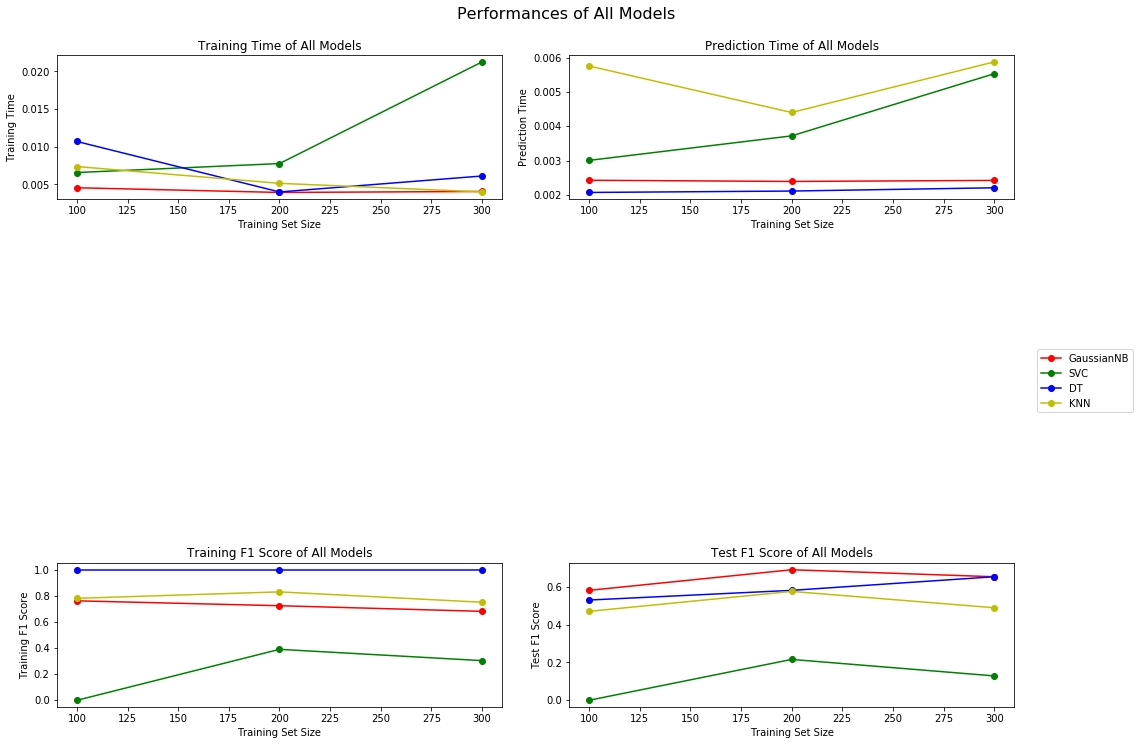

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

training_size = [100, 200, 300]
models = ['GaussianNB', 'SVC', 'DT', 'KNN']
metrics = ['Training Time', 'Prediction Time', 'Training F1 Score', 'Test F1 Score']

fig = plt.figure(figsize=(16, 10))

for k, metric in enumerate(metrics): 
    ax = fig.add_subplot(2, 2, k+1)
    ax.plot(training_size, results[metric]['GaussianNB'], 'o-', color = 'r', label = 'GaussianNB')
    ax.plot(training_size, results[metric]['SVC'], 'o-', color = 'g', label = 'SVC')
    ax.plot(training_size, results[metric]['DT'], 'o-', color = 'b', label = 'DT')
    ax.plot(training_size, results[metric]['KNN'], 'o-', color = 'y', label = 'KNN')
    


    # Labels
    ax.set_title('{} of All Models'.format(metric))
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel(metric)
    

# Visual aesthetics
ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
fig.suptitle('Performances of All Models', fontsize = 16, y = 1.03)
fig.tight_layout()
fig.show()

#### Answer: 

The DT classifier is apparently overfitting because it classifies the training data perfectly, with a F1 score of 1.0 for the training set. Compared to the KNN classifier, both SVM classiifer and NB classifier have better performances. SVC has the longest training time and the second longest prediction time. DT and NB have constantly low training and prediction times. KNN has the shortest training time but the longest prediction time. Given that the dataset in this problem is relatively small, computational cost would not be the major concern. Therefore, we should go with SVC for its slightly better performance.

### Implementation: Model Tuning

Fine tune the chosen model. Use grid search (GridSearchCV) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:

-Import sklearn.grid_search.gridSearchCV and sklearn.metrics.make_scorer.

-Create a dictionary of parameters you wish to tune for the chosen model.

 -Example: parameters = {'parameter' : [list of values]}.

-Initialize the classifier you've chosen and store it in clf.

-Create the F1 scoring function using make_scorer and store it in f1_scorer.
   
   -Set the pos_label parameter to the correct value!

-Perform grid search on the classifier clf using f1_scorer as the scoring method, and store it in grid_obj.

-Fit the grid search object to the training data (X_train, y_train), and store it in grid_obj.

In [45]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {'kernel':('linear','rbf'),
              'C':(0.01, 0.1, 1, 10),
              'gamma': (0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1),
              'class_weight': (None, 'balanced')}

# TODO: Initialize the classifier
clf = SVC(random_state=912,kernel='rbf')


# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label=1)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print ("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)[1]))
print ("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)[1]))
print ("\nTuned model: {}".format(clf))

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/m

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/m

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/m

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/m

Tuned model has a training F1 score of 0.7238.
Tuned model has a testing F1 score of 0.6667.

Tuned model: SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
    max_iter=-1, probability=False, random_state=912, shrinking=True, tol=0.001,
    verbose=False)


In [46]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label=1)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer, cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning


# Report the final F1 score for training and testing after parameter tuning
print ("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)[1]))
print ("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)[1]))
print ("\nTuned model: {}".format(clf))

Tuned model has a training F1 score of 0.8207.
Tuned model has a testing F1 score of 0.5000.

Tuned model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=2,
              silent=None, subsample=0.8, verbosity=1)


In [47]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {
      'C': [ 1.0, 10, 100],
      'class_weight': ['balanced', None],
      'max_iter' : [10,100,200]
}

# TODO: Initialize the classifier
clf = LogisticRegression()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label=1)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer, cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning


# Report the final F1 score for training and testing after parameter tuning
print ("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)[1]))
print ("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)[1]))
print ("\nTuned model: {}".format(clf))

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' 

/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

Tuned model has a training F1 score of 0.7517.
Tuned model has a testing F1 score of 0.6970.

Tuned model: LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/kaysuh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Let's predict winning odds !

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import itertools

# Set a pipeline with Scaler and Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs',
                                      random_state=27))
])

SVC_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=27))
])

XGB_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(seed = 82))
])  



In [50]:
# Train the model
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=27,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [52]:
# Get score for evaluation
pipeline.score(X_test,y_test)

0.8245614035087719

In [53]:
# Get score with train data
pipeline.score(X_train, y_train)

0.8903508771929824

In [51]:
# Train the model
SVC_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=27, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [54]:
# Get score for evaluation
SVC_pipeline.score(X_test,y_test)

0.7982456140350878

In [55]:
# Get score with train data
SVC_pipeline.score(X_train, y_train)

0.8969298245614035

In [56]:
# Train the model
XGB_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=82, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [66]:
# Get score for evaluation
XGB_pipeline.score(X_test,y_test)

0.8245614035087719

In [57]:
# Get score with train data
XGB_pipeline.score(X_train, y_train)

0.9627192982456141

In [58]:
stat_AL_0902 = {
    # EAST
    'NYY': [.270, .828, 4.44, 1.31, .982, .696],
    'TB':  [.254, .756, 3.66, 1.19, .985, .695],
    'BOS': [.275, .826, 4.68, 1.37, .985, .677],
    'TOR': [.236, .727, 4.71, 1.43, .984, .688],
    'BAL': [.246, .721, 5.77, 1.47, .981, .692],
    
    # CENTRAL
    'MIN': [.273, .842, 4.16, 1.30, .981, .678],
    'CLE': [.251, .761, 3.67, 1.21, .984, .698],
    'CWS': [.255, .707, 4.96, 1.44, .979, .679],
    'KC':  [.243, .704, 5.15, 1.47, .987, .678],
    'DET': [.238, .682, 5.19, 1.45, .981, .677],

    # WEST
    'HOU': [.274, .839, 3.69, 1.14, .987, .722],
    'OAK': [.249, .772, 4.06, 1.26, .986, .711],
    'TEX': [.246, .748, 4.86, 1.44, .982, .677],
    'LAA': [.252, .762, 5.01, 1.37, .983, .694],
    'SEA': [.241, .756, 5.04, 1.39, .977, .689],
}

In [59]:
al_predicts = {}
for team, value in stat_AL_0902.items():
    proba = XGB_pipeline.predict_proba([value])[0][1]*100
    al_predicts[team] = proba
    print(f'{team} :  {proba:.3}%')
    


NYY :  88.6%
TB :  61.7%
BOS :  88.7%
TOR :  1.26%
BAL :  0.195%
MIN :  92.8%
CLE :  60.3%
CWS :  0.138%
KC :  0.111%
DET :  0.0895%
HOU :  78.7%
OAK :  83.3%
TEX :  0.276%
LAA :  1.1%
SEA :  0.834%


In [60]:
al_predicts

{'NYY': 88.6336624622345,
 'TB': 61.70663833618164,
 'BOS': 88.69322538375854,
 'TOR': 1.2624830938875675,
 'BAL': 0.195356085896492,
 'MIN': 92.82560348510742,
 'CLE': 60.2580726146698,
 'CWS': 0.13821548782289028,
 'KC': 0.11051865294575691,
 'DET': 0.08952833013609052,
 'HOU': 78.68287563323975,
 'OAK': 83.25449228286743,
 'TEX': 0.2762458985671401,
 'LAA': 1.1003670282661915,
 'SEA': 0.8335691876709461}

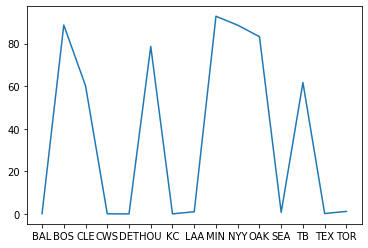

In [61]:
import matplotlib.pyplot as plt


plt.plot(*zip(*sorted(al_predicts.items())))
plt.show()

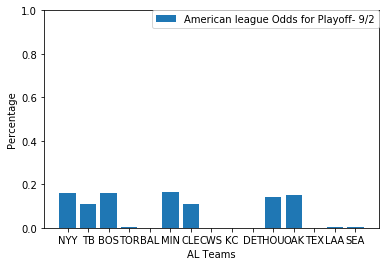

In [62]:
import matplotlib.pyplot as plt
import numpy as np



keys = al_predicts.keys()
vals = al_predicts.values()

plt.bar(keys, np.divide(list(vals), sum(vals)), label="American league Odds for Playoff- 9/2")

plt.ylim(0,1)
plt.ylabel ('Percentage')
plt.xlabel ('AL Teams')
plt.xticks(list(keys))
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()


In [63]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-colorblind')

In [64]:
def draw_bar_chart(predicts, title):
    """Draw a bar chart with Seaborn"""
    # Draw chart with Seaborn
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=list(predicts.keys()), y=list(predicts.values()), ax=ax)
    sns.despine(fig)

    ax.grid(False)
    ax.set_yticks([])

    fig.suptitle(title, fontsize=20)

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = '{:.1f}%'.format(y_value)
        plt.annotate(label, (x_value, y_value), ha='center', fontsize=10)
    
    filename = 'output.png'
    fig.savefig(filename)
    plt.show()

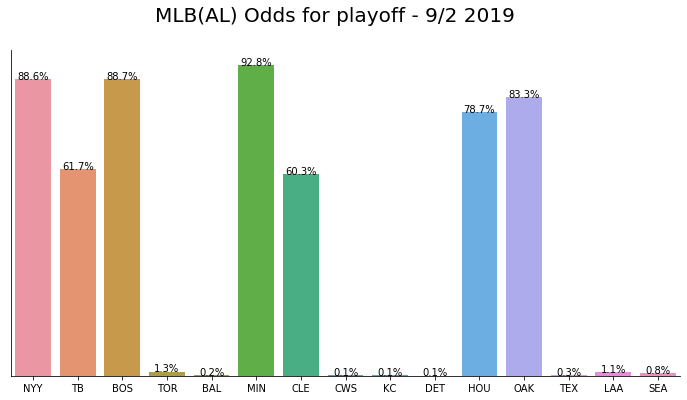

In [65]:
draw_bar_chart(al_predicts, 'MLB(AL) Odds for playoff - 9/2 2019')

In [66]:
stat_NL_0902 = {
    # EAST
    'ATL': [.260, .794, 4.24, 1.39, .986, .683],
    'WSH': [.264, .795, 4.31, 1.30, .985, .688],
    'PHI': [.248, .750, 4.60, 1.38, .984, .690],
    'NYM': [.257, .762, 4.34, 1.32, .982, .682],
    'MIA': [.239, .663, 4.77, 1.34, .984, .714],


    # CENTRAL
    'STL': [.247, .731, 3.89, 1.26, .988, .710],
    'CHC': [.251, .778, 4.04, 1.30, .982, .694],
    'MIL': [.248, .768, 4.63, 1.37, .984, .690],
    'CIN': [.247, .744, 4.23, 1.28, .985, .695],
    'PIT': [.268, .755, 5.06, 1.43, .980, .674],


    # WEST
    'LAD': [.260, .820, 3.45, 1.11, .982, .711],    
    'ARI': [.258, .776, 4.39, 1.32, .987, .693],
    'SF':  [.242, .710, 4.45, 1.31, .985, .697],
    'SD':  [.244, .736, 4.60, 1.30, .980, .686],
    'COL': [.268, .784, 5.67, 1.51, .983, .674],
}

In [70]:
nl_predicts = {}
for team, value in stat_NL_0902.items():
    proba = XGB_pipeline.predict_proba([value])[0][1]*100
    nl_predicts[team] = proba
    print(f'{team} :  {proba:.3}%')

ATL :  43.8%
WSH :  82.6%
PHI :  1.56%
NYM :  4.01%
MIA :  0.21%
STL :  52.5%
CHC :  88.7%
MIL :  7.86%
CIN :  5.51%
PIT :  0.386%
LAD :  96.7%
ARI :  52.2%
SF :  0.725%
SD :  1.31%
COL :  0.806%


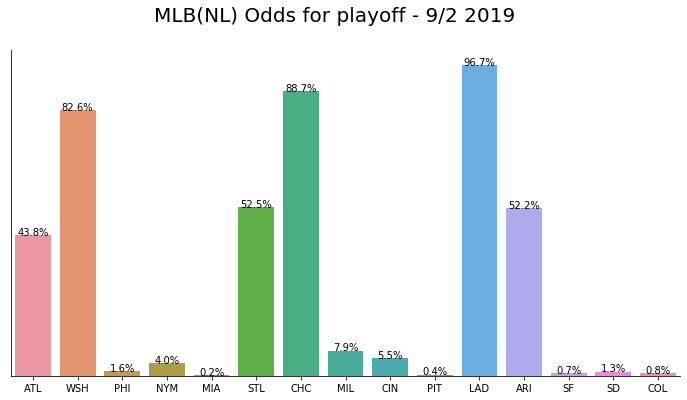

In [71]:
draw_bar_chart(nl_predicts, 'MLB(NL) Odds for playoff - 9/2 2019')

In [72]:
nl_predicts = {}
for team, value in stat_NL_0902.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    nl_predicts[team] = proba
    print(f'{team} :  {proba:.3}%')

ATL :  66.8%
WSH :  62.2%
PHI :  2.04%
NYM :  16.8%
MIA :  0.00406%
STL :  16.6%
CHC :  60.2%
MIL :  4.74%
CIN :  8.75%
PIT :  0.469%
LAD :  99.7%
ARI :  24.7%
SF :  0.42%
SD :  0.967%
COL :  0.121%
